In [1]:
%matplotlib notebook
%load_ext Cython
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys 
sys.path.append('/home/pablo/CinePy')

from modules.point_kinetics.reactimeter import reactimetro
from modules.point_kinetics.io_modules import lee_reactimetro
from constantes.lectura import lee_constantes_retardados
from constantes.constantes_reactores import RA3 

In [2]:
archivos = [
            "E01_potencia_cajas.AI.D1.bin",
            ]

<IPython.core.display.Javascript object>


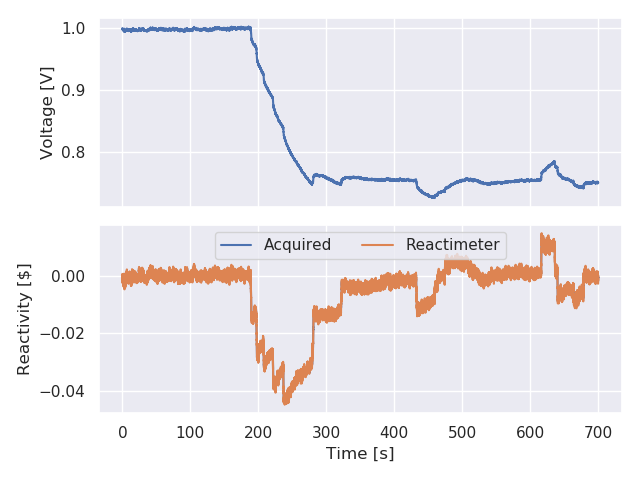

In [3]:
fig1, ax = plt.subplots(2, 1, sharex=True)
for archivo in archivos:
    n, rho, t, sdn, dt, head = lee_reactimetro(archivo)
    ind = t < 700
    n = n[ind]
    rho = rho[ind]
    t = t[ind]
    sdn = sdn[ind]

    ax[0].plot(t, n/n[0], label="Acquired")
    ax[1].plot(t, rho, label="Acquired")

ax[0].set_ylabel('Voltage [V]')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Reactivity [$]')
ax[1].legend(loc="upper center", ncol=2)

fig1.tight_layout()
plt.show()

In [4]:
# Delayed neutron constants 
b, lam , beta = lee_constantes_retardados('Tuttle')
# Reduced generation time
Lambda_red = RA3.LAMBDA_REDUCIDO
# dt read from header of data file
for line in head:
    if line.startswith(b"Frecuencia sampleo procesamiento"):
        dt = line.split()[-1]
        dt = 1 / float(dt)

In [5]:
rho_r, t_r, _ = reactimetro(n, dt, lam, b, Lambda_red)
ax[1].plot(t_r, rho_r, label="Reactimeter")
ax[1].legend(loc="upper center", ncol=2)
fig1.tight_layout()

In [6]:
%%cython
cimport cython
import numpy as np

def reactimetro(double[:] n, double dt, double[:] lam, double[:] b, double Lstar, Q_in=0.0):
    """
    Solves numercally the inverse kinetics equation to get the reactivity as a function of time

    Parameters:
    -----------
        n : np.array (float)
            Neutron density
        dt : float
            Time interval separation between each point in n
        lam : np.array (float)
            Decay consants of delayed precursors
        b : np.array (float)
            Delayed neutron fracction (beta_i / beta) (nuclear or effective)
        Lstar : float
            Reduced reproduction time (Lambda / beta_effective)
        Q_in : float or np.array (float)
            Strenght of the neutron source. If it is not a constast, it should satisfy len(Q_in)=len(n)

    Returns:
    --------
        rho : np.array (float)
            Reactivity as a function of time
        t : np.array(float)
            Time
        D : np.array (float)
            Auxiliary variable only used in the inverse kinetic method to obtain neutron source strength
    """

    cdef int Nr, Ng, k, j
    cdef double lam_c_sum, lam_c_sum_LabVIEW
    cdef double[:] rho, Q, e, D, t
    cdef double[:,:] c

    # Number of points
    Nr = np.size(n)
    # Number of delayed neutron groups
    Ng = np.size(lam)
    # Precursors concentrations
    c = np.zeros((Ng, Nr))
    # Reactivity
    rho = np.zeros(Nr)
    # Auxiliar variable
    D = np.zeros(Nr)
    # Initially, precursors at equilibrium
    for k in range(Ng):
        c[k, 0] = n[0] * b[k] / lam[k] / Lstar
    if np.size(Q_in) == 1:
        Q = Q_in * np.ones_like(n)
    elif np.size(Q_in) != Nr:
        raise ValueError('El vector Q no tiene el mismo tamaño que n')

    # Initial reactivity
    rho[0] = - Lstar * Q[0] / n[0]
    e = np.zeros(Ng)
    for j in range(Ng):
        e[j] = np.exp(-lam[j] * dt)
    for k in range(1, Nr):
        D[k] = (n[k] - n[k-1]) / dt
        for j in range(Ng):
            c[j, k] = c[j, k-1] * e[j] + b[j] / lam[j] / Lstar * (n[k-1]*(1-e[j]) - (1-e[j])*(n[k]-n[k-1]) / lam[j] / dt + n[k] - n[k-1])
            # As in LabVIEW
            # D[k] -= lam[j] * c[j, k-1]
            D[k] -= lam[j] * c[j, k]
        # As in LabVIEW
        # rho[k] = 1 + Lstar / n[k-1] *(D[k] - Q[k])
        # As it should be
        rho[k] = 1 + Lstar / n[k] *(D[k] - Q[k])
    t = np.arange(0, Nr) * dt

    return rho, t, D